<a href="https://colab.research.google.com/github/Rangulov/Price-Prediction/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%86%D0%B5%D0%BD%D1%8B_%D0%BD%D0%B5%D0%B4%D0%B2%D0%B8%D0%B6%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8_%D0%B2_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B5_%D0%B8_%D0%9C%D0%BE%D1%81%D0%BA%D0%BE%D0%B2%D1%81%D0%BA%D0%BE%D0%B9_%D0%BE%D0%B1%D0%BB%D0%B0%D1%81%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

### Функция для подсчета метрик модели

In [99]:
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

    #R^2
    r2 = model.score(X_test, y_test)
    # Количество наблюдений
    n = X_test.shape[0]
    # Число признаков
    p = X_test.shape[1]
    # Скорректированный
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    print(f'MAE:  {round(MAE,4)}\n  RMSE: {round(RMSE,4)}\n MAPE: {round(MAPE, 4)}\n Adjusted r2: {round(adjusted_r2,4)}\n R2: {round(R2,4)}\n Cross Validated R2: {round(CV_R2,4)}')
    return MAE, RMSE, MAPE, adjusted_r2, R2, CV_R2

## Просмотр данных

In [100]:
df = pd.read_csv('data.csv')

In [101]:
df.shape

(22676, 12)

In [102]:
df.head()

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.6,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.2,20.0,10.0,6.0,15,European-style renovation
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.7,16.2,13.1,10.0,25,Cosmetic
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.1,16.0,11.0,12.0,33,European-style renovation
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.7,15.2,4.0,5.0,5,Without renovation


Таблица имеет 22676 записей и 12 признаков из которых один (цена это целевая переменная)

*   price - цена
*   Apartment type - тип квартиры (вторичка или новостройка)
*   Metro station - ближайщее метро
*   Minutes to metro - время до метро
*   Region - где находится (в москве или в области)
*   Number of rooms - количество комнат
*   Area - площадь квартиры
*   Live area - жилая площадь
*   Kitchen area - площадь кухни
*   Floor - этаж квартиры
*   Number of floors - число этажей в доме
*   Renovation - тип ремонта

In [103]:
df.describe()

,Price,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors
count,2.267600e+04,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000
mean,3.612132e+07,11.888605,2.043129,71.966827,38.517953,12.594082,9.190466,16.556095
std,8.282561e+07,6.204457,1.523586,68.368608,38.124278,7.728074,7.549996,9.779297
min,1.150000e+06,0.000000,0.000000,6.000000,2.000000,1.000000,1.000000,1.000000
25%,7.068116e+06,7.000000,1.000000,37.400000,17.600000,8.600000,4.000000,11.000000
50%,1.134320e+07,11.000000,2.000000,53.300000,28.500000,10.600000,8.000000,16.000000
75%,2.479925e+07,15.000000,3.000000,77.140000,43.200000,14.500000,13.000000,20.000000
max,2.455020e+09,60.000000,12.000000,1117.000000,566.800000,122.000000,92.000000,97.000000


In [104]:
df.describe(include=['O'])

,Apartment type,Metro station,Region,Renovation
count,22676,22676,22676,22676
unique,2,547,2,4
top,Secondary,Красногвардейская,Moscow,Cosmetic
freq,13152,2697,16113,12788


In [105]:
df["Metro station"].value_counts()

,count
Metro station,
Красногвардейская,2697
Депо,1646
Братиславская,1157
Котельники,981
Жулебино,731
...,...
Сколково,1
Мякинино,1
Терехово (Мнёвники),1


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22676 entries, 0 to 22675
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             22676 non-null  float64
 1   Apartment type    22676 non-null  object 
 2   Metro station     22676 non-null  object 
 3   Minutes to metro  22676 non-null  float64
 4   Region            22676 non-null  object 
 5   Number of rooms   22676 non-null  float64
 6   Area              22676 non-null  float64
 7   Living area       22676 non-null  float64
 8   Kitchen area      22676 non-null  float64
 9   Floor             22676 non-null  float64
 10  Number of floors  22676 non-null  int64  
 11  Renovation        22676 non-null  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 2.1+ MB


**Анализ таблицы**

В нашей таблице 8 числовых столбцов и 4 категориальных признака:
*   Apartment type: с 2 уникальными значениями
*   Metro station: с 547 уникальными значениями
*   Region: с 2 уникальными значениями
*   Renovation: с 4 уникальными значениями
***
**Цена**

mean = 36,121,321 рублей

min = 1,150,000 рублей

max = 2,455,020,000 рублей

(25% : 75%) = (7,068,116 руб. : 24,799,247 руб.)


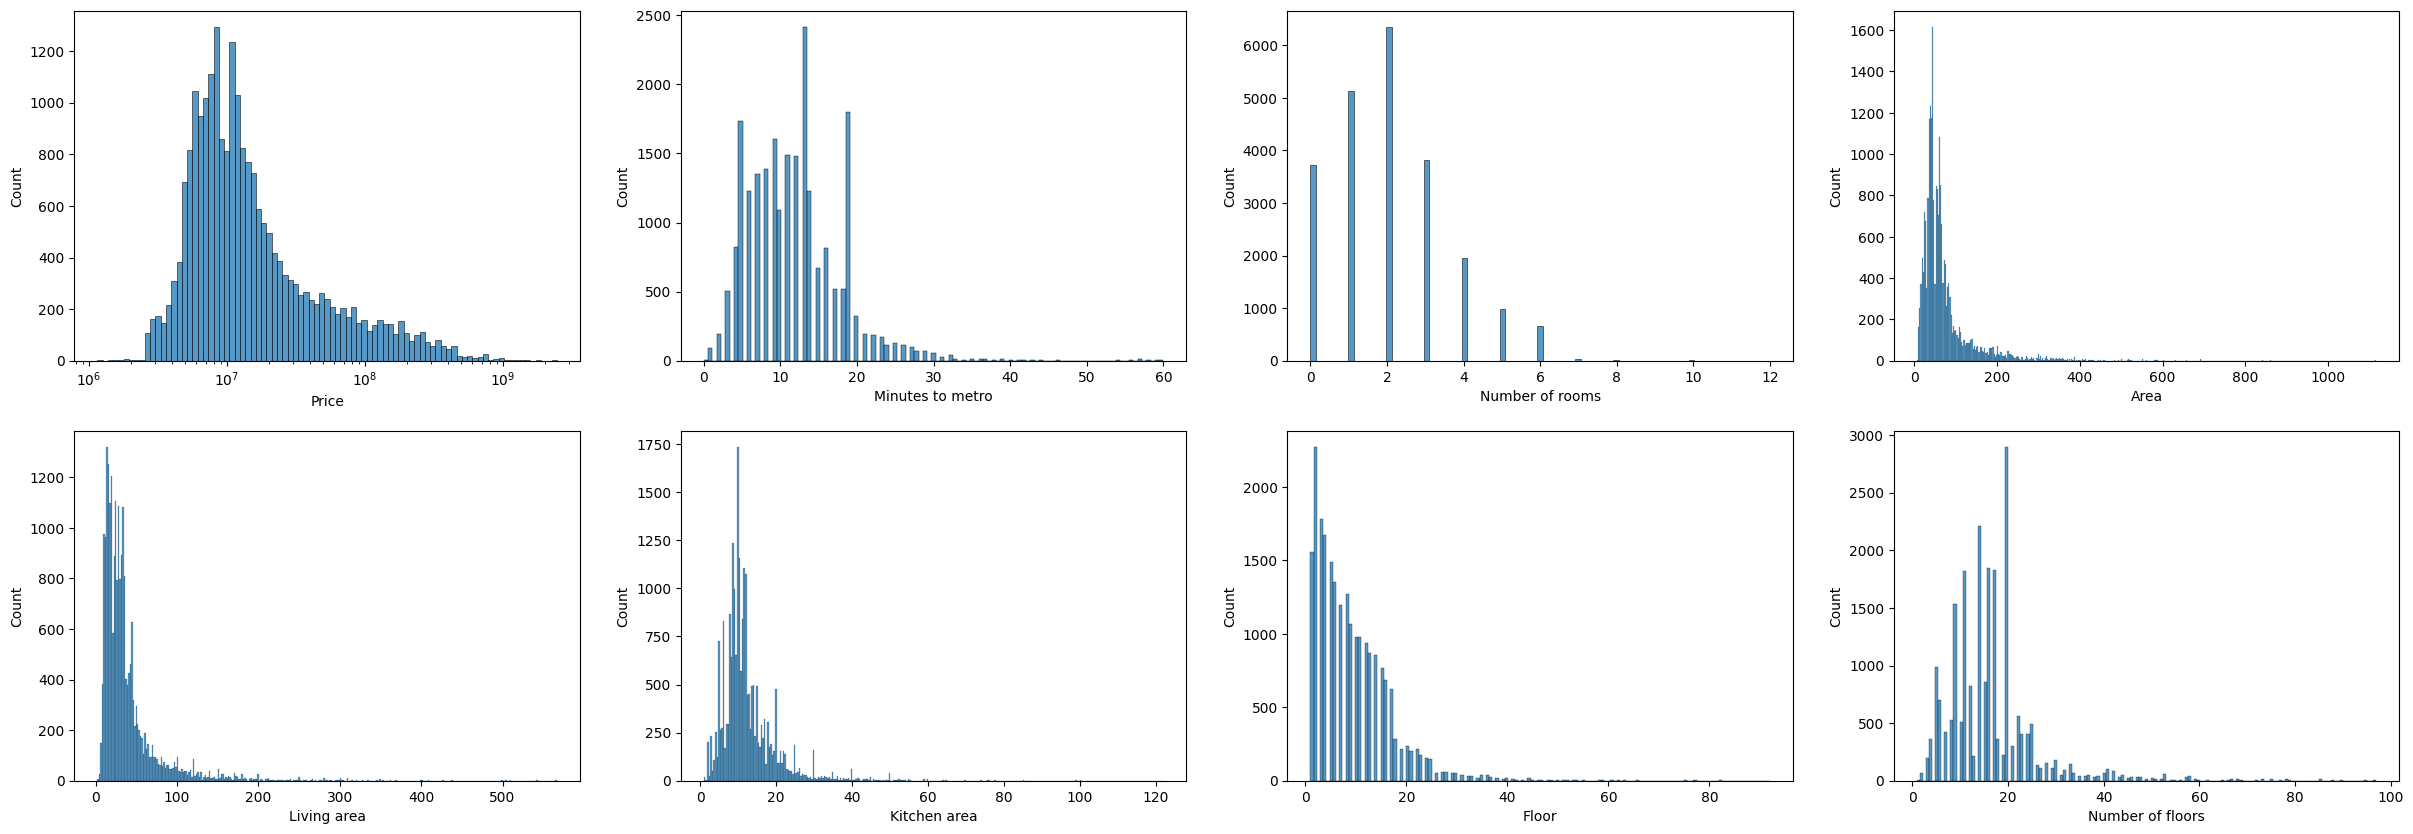

In [107]:
f, ax = plt.subplots(2, 4, figsize=(30,10))

sns.histplot(data=df, x="Price", ax = ax[0, 0], log_scale = 10)

sns.histplot(data=df, x="Minutes to metro", ax = ax[0, 1])

sns.histplot(data=df, x="Number of rooms", ax = ax[0, 2])

sns.histplot(data=df, x="Area", ax = ax[0, 3])

sns.histplot(data=df, x="Living area", ax = ax[1, 0])

sns.histplot(data=df, x="Kitchen area", ax = ax[1, 1])

sns.histplot(data=df, x="Floor", ax = ax[1, 2])

sns.histplot(data=df, x="Number of floors", ax = ax[1, 3])

plt.show()

<Axes: xlabel='Price'>

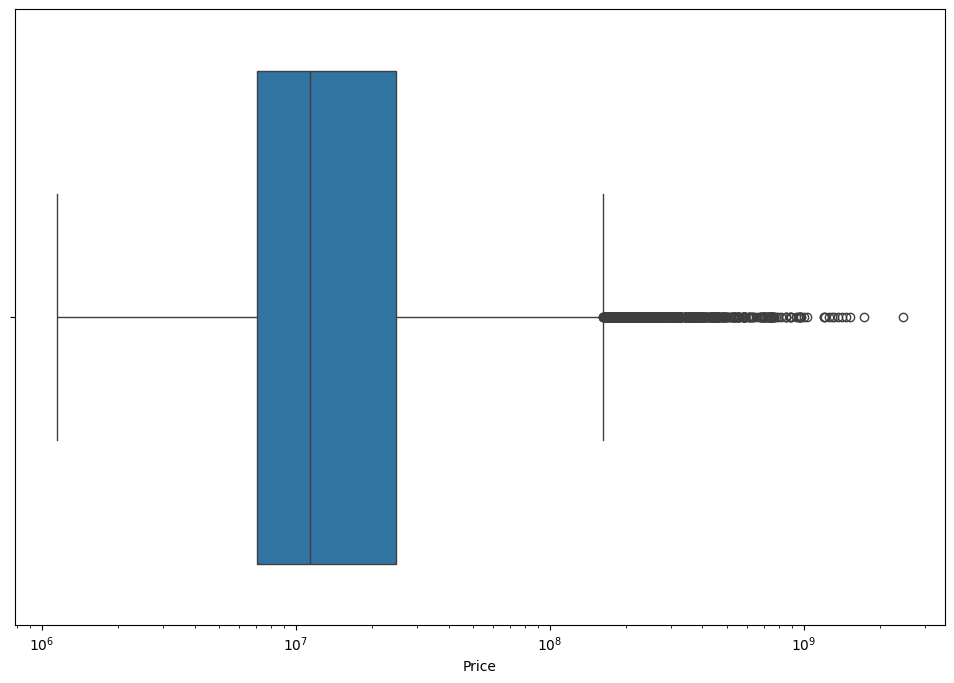

In [108]:
sns.boxplot(data=df, x="Price", log_scale = 10)

### Работа с категориальными признаками

In [109]:
# Убираем лишние пробелы и все названия станция делаем с маленьков буквы
df['Metro station'] = df['Metro station'].str.lower().str.strip()

In [110]:
df['Metro station'].nunique()

310

In [111]:
df["Metro station"].value_counts()

,count
Metro station,
красногвардейская,2698
депо,1647
братиславская,1161
котельники,981
жулебино,731
...,...
хлебниково,1
лубянка,1
долгопрудная,1


Количество уникальных занчений в данном столбце уменьшилось -> были дубликаты в данных, которые мы преобразовали.

Заметим, что даже так большОе число уникальных значений, и их "неудобно" закодировать каким-нибудь известным методом Encoding. Лучший вариант это конечно подобрать подходящие веса под каждую станцию метро, но это уже отдельная задача.

Поэтому удалим стоблец `Metro Station`, очевидно он несильно влият на `Price`, потому что те станции где квартиры очевидно дорогие являются выбросами и их количество очень мало по сравнению с числом записей в таблице.

In [113]:
df = df.drop(["Metro station"], axis = 1)

**Остальные категориальные признаким:**

*   `Apartment type`
*   `Region`
*   `Renovation `

Закодируем с помощью метода OrdinalEncoding с логичными значениями.

In [114]:
df['Apartment type'].unique()

array(['Secondary', 'New building'], dtype=object)

In [115]:
df['Region'].unique()

array(['Moscow region', 'Moscow'], dtype=object)

In [116]:
df['Renovation'].unique()

array(['Cosmetic', 'European-style renovation', 'Without renovation',
       'Designer'], dtype=object)

In [117]:
Apart = ['Secondary', 'New building']
Region = ['Moscow region', 'Moscow']
Renovation = ['Without renovation', 'Cosmetic', 'European-style renovation',
       'Designer']

encoder_apart = OrdinalEncoder(categories = [Apart])
encoder_region = OrdinalEncoder(categories = [Region])
encoder_renovation = OrdinalEncoder(categories = [Renovation])

df['Apartment type encoded'] = encoder_apart.fit_transform(df[['Apartment type']])
df['Region encoded'] = encoder_region.fit_transform(df[['Region']])
df['Renovation encoded'] = encoder_renovation.fit_transform(df[['Renovation']])

In [119]:
df = df.drop(["Apartment type", "Region", "Renovation"], axis = 1)

In [120]:
df.head()

,Price,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Apartment type encoded,Region encoded,Renovation encoded
0,6300000.0,6.0,1.0,30.6,11.1,8.5,25.0,25,0.0,0.0,1.0
1,9000000.0,2.0,1.0,49.2,20.0,10.0,6.0,15,0.0,0.0,2.0
2,11090000.0,14.0,1.0,44.7,16.2,13.1,10.0,25,0.0,0.0,1.0
3,8300000.0,8.0,1.0,35.1,16.0,11.0,12.0,33,0.0,0.0,2.0
4,6450000.0,6.0,1.0,37.7,15.2,4.0,5.0,5,0.0,0.0,0.0


### Матрица корреляций


Далее визуализируем взаимосвязь между признаками и посмотрим мультиколлинеарность среди числовых признаков

Text(0.5, 1.0, 'Матрица корреляций')

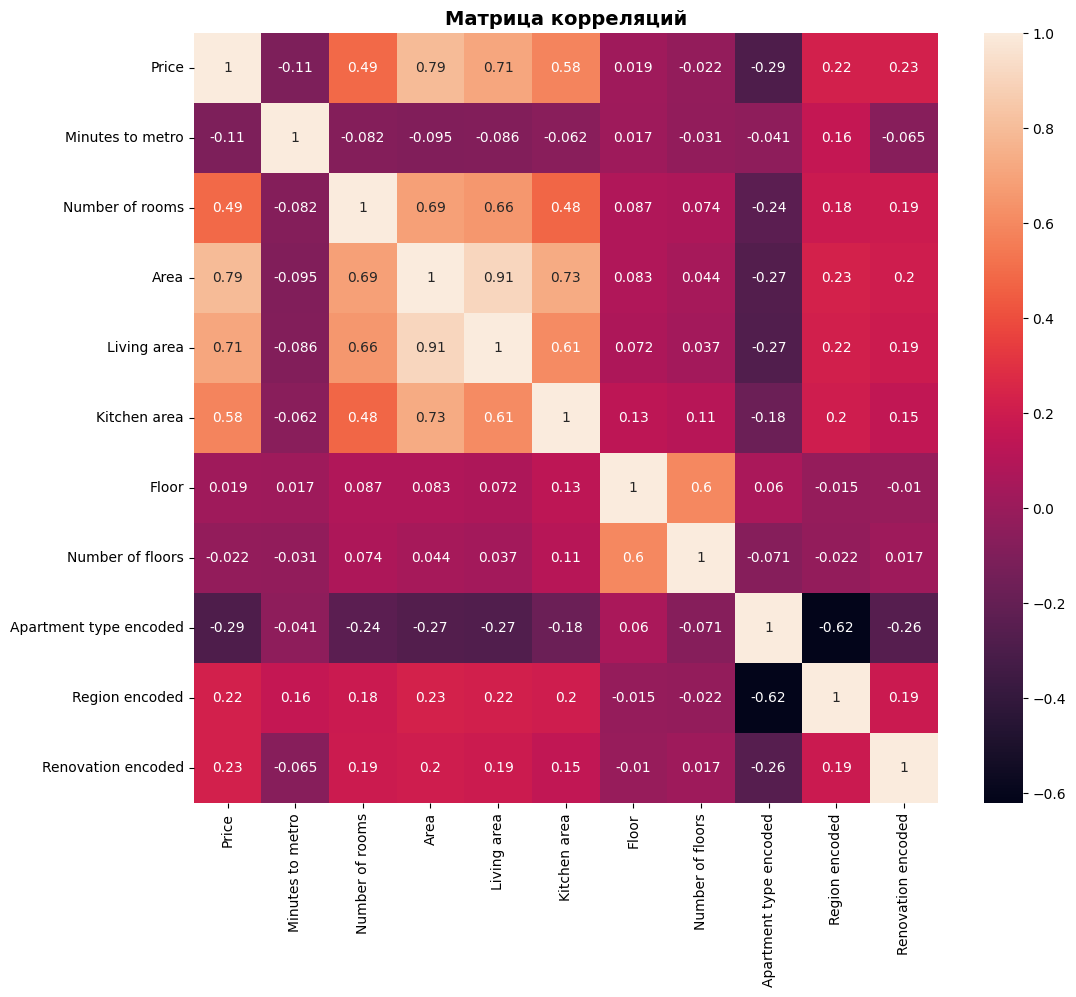

In [121]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))

# Построим матрицу корреляций
corr = df.select_dtypes(include = ['float64', 'int64']).corr()
sns.heatmap(corr, annot = True)

ax.set_title('Матрица корреляций', fontsize=14)

**Матрица корреляции**
1. Существует линейная зависимость между Price (целевая переменная) и следующими признаками:
   -  `Number of rooms`
   -  `Area`
   -  `Living area`
   -  `Kitchen area`
2. Существует мультиколлинеарность между признаками `Area` и `Living area`
Так как среди данных переменных наблюдается мультиколлинеарность, то удалим менее значимый признак `Living area`
3. Так же сильная корреляция наблюдается между другими признаками
Нарприме: `Kitchen area` линейно зависима от `Numbers of rooms`

То есть из этой информации делаем вывод, что чем больше комнат - тем больше площадь кухни квартиры и соответственно тем больше цена квартиры (это только один из выводов, которые можно сделать)

Вывод: Cильная корреляция наблюдается только между целевой переменной и тремя числовыми признаками

Далее удалим признак `Living area` и просмотрим промежуточный наборы данных

In [122]:
df = df.drop(["Living area"], axis = 1)

In [123]:
df.head()

,Price,Minutes to metro,Number of rooms,Area,Kitchen area,Floor,Number of floors,Apartment type encoded,Region encoded,Renovation encoded
0,6300000.0,6.0,1.0,30.6,8.5,25.0,25,0.0,0.0,1.0
1,9000000.0,2.0,1.0,49.2,10.0,6.0,15,0.0,0.0,2.0
2,11090000.0,14.0,1.0,44.7,13.1,10.0,25,0.0,0.0,1.0
3,8300000.0,8.0,1.0,35.1,11.0,12.0,33,0.0,0.0,2.0
4,6450000.0,6.0,1.0,37.7,4.0,5.0,5,0.0,0.0,0.0


## Обучение

### Разделим данные на обучаемую и тестовую выборку

In [ ]:
X = df.copy()

X.drop(['Price'], axis = 1, inplace = True)
y = df['Price']

category = list(X.select_dtypes(include = ['object']).columns)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)